In [1]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.4/819.4 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 21.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.1/118.1 kB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2

In [2]:
!unzip /content/drive/MyDrive/pjm.zip

Archive:  /content/drive/MyDrive/pjm.zip
  inflating: AEP_hourly.csv          
  inflating: COMED_hourly.csv        
  inflating: DAYTON_hourly.csv       
  inflating: DEOK_hourly.csv         
  inflating: DOM_hourly.csv          
  inflating: DUQ_hourly.csv          
  inflating: EKPC_hourly.csv         
  inflating: FE_hourly.csv           
  inflating: NI_hourly.csv           
  inflating: PJME_hourly.csv         
  inflating: PJMW_hourly.csv         
  inflating: PJM_Load_hourly.csv     
  inflating: est_hourly.paruqet      
  inflating: pjm_hourly_est.csv      


In [5]:
!unzip chick.zip

Archive:  chick.zip
  inflating: hungary_chickenpox.csv  
  inflating: hungary_county_edges.csv  


In [6]:
import pandas as pd
import torch
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.models import TFTModel
import matplotlib.pyplot as plt
from darts.explainability import TFTExplainer

quantiles = [
    0.1,
    0.5,
    0.9
]

input_chunk_length = 100
forecast_horizon = 1

### prepare PJME dataset

In [7]:
def prepare_electricity(electricity_df):
    electricity_df.rename(columns = {'Datetime':'date'}, inplace = True)
    electricity_df.drop_duplicates(subset = 'date')
    electricity_df['y'] = electricity_df.groupby('date')['PJME_MW'].transform('sum')
    electricity_df['date'] = pd.to_datetime(electricity_df["date"])
    electricity_df.drop_duplicates(subset = ['date'],inplace=True)
    # el.drop(columns = ['date', 'time'], inplace = True)
    electricity_df.set_index('date', inplace = True)
    electricity_df = electricity_df[electricity_df.index.year>2010]
    el_train = electricity_df[electricity_df.index.year<2017]
    el_val = electricity_df[electricity_df.index.year>=2017]

    electricity_series_train = TimeSeries.from_dataframe(el_train, value_cols =  "y", fill_missing_dates=True, freq="H")
    electricity_series_val = TimeSeries.from_dataframe(el_val, value_cols = "y", fill_missing_dates=True, freq="H")
    electricity = TimeSeries.from_dataframe(el, value_cols =  "y", fill_missing_dates=True, freq="H")
    return electricity_series_train, electricity_series_val,electricity

In [8]:
def prepare_chick(chick):
    chick['date'] = pd.to_datetime(chick["Date"], dayfirst = True)
    chick.drop_duplicates(subset = ['date'],inplace=True)
    chick.drop(columns = ['Date'], inplace = True)
    chick.set_index('date', inplace = True)
    chick = chick[chick.index.year>=2008]
    chick_train, chick_val = chick[chick.index.year<=2013], chick[chick.index.year>2013]
    chick_series_train = TimeSeries.from_dataframe(chick_train, value_cols = cols, fill_missing_dates=True, freq="7D")
    chick_series_val = TimeSeries.from_dataframe(chick_val, value_cols = cols, fill_missing_dates=True, freq="7D")
    chick = TimeSeries.from_dataframe(chick, value_cols =  cols, fill_missing_dates=True, freq="7D")
    return chick_series_train, chick_series_val, chick

In [9]:
def plot_train_val(train, val, name):
    train.plot(label="train")
    val.plot(label="val")
    plt.title(name)
    plt.show()

In [10]:
def prepare_mg(mg):
    mg['date'] = pd.date_range(start="01-01-2000", periods=mg.shape[0], freq="D")
    mg.set_index('date', inplace = True)
    mg_train = mg[mg.index.year<2020]
    mg_val = mg[mg.index.year>=2020]
    mg_series_train = TimeSeries.from_dataframe(mg_train, value_cols =  "y", fill_missing_dates=True, freq="D")
    mg_series_val = TimeSeries.from_dataframe(mg_val, value_cols = "y", fill_missing_dates=True, freq="D")
    mg = TimeSeries.from_dataframe(mg, value_cols =  "y", fill_missing_dates=True, freq="D")
    return mg_series_train, mg_series_val, mg

In [11]:
el = pd.read_csv('PJME_hourly.csv')
el.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [12]:
mg_df = pd.read_csv('mg.csv')
mg_df.head()

,y
0,1.200000
1,1.188060
2,1.176238
3,1.164535
4,1.152947


In [13]:
chick_df = pd.read_csv('hungary_chickenpox.csv')

In [14]:
cols = ['BUDAPEST', 'BARANYA', 'BACS', 'BEKES', 'BORSOD']

In [15]:
chick_train, chick_val, chick = prepare_chick(chick_df)

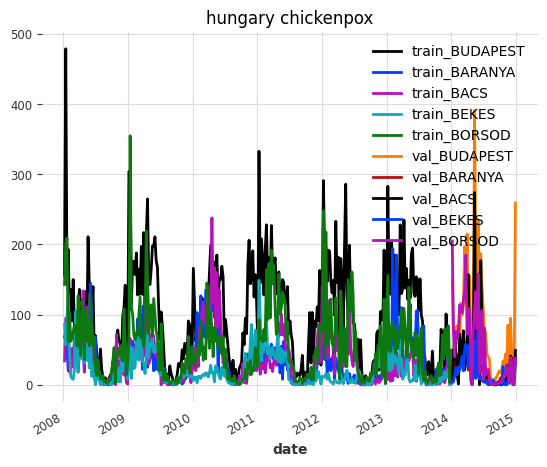

In [16]:
plot_train_val(chick_train, chick_val, 'hungary chickenpox')

In [17]:
mg_train, mg_val, mg = prepare_mg(mg_df)

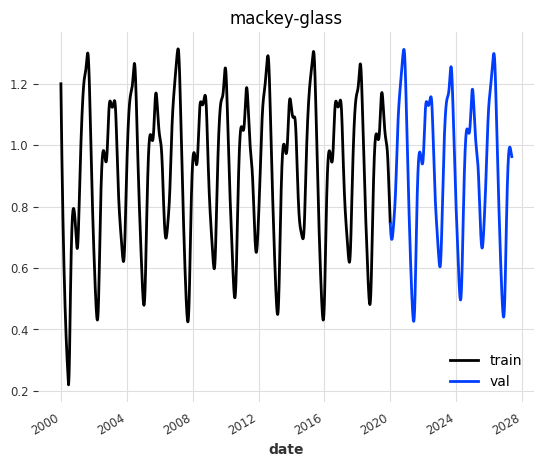

In [18]:
plot_train_val(mg_train, mg_val, 'mackey-glass')

###Read and cleanup data

In [19]:
el_train, el_val,el_series = prepare_electricity(el)

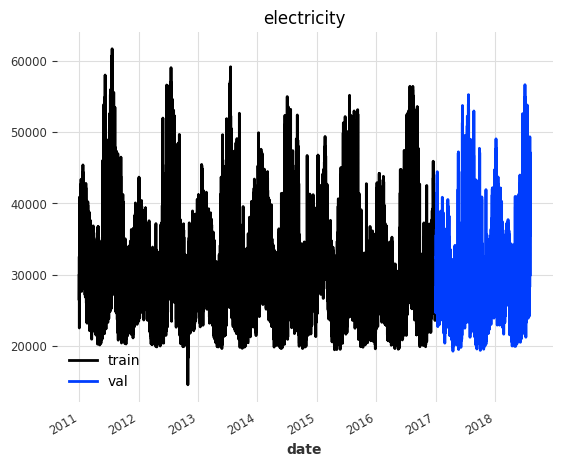

In [20]:
plot_train_val(el_train, el_val, 'electricity')

In [21]:
datasets = {
    'chickenpox': {
        'series': chick,
        'train_raw': chick_train,
        'val_raw':chick_val,
        'train':{},
        'val':{},
        'train_cov':{},
        'val_cov':{},
        'covariates': {},
        'covs':["month", "year", "week"],
        'input_length':12,
        'future_length':8
    },
    'mackey-glass': {
        'series': mg,
        'train_raw':mg_train,
        'val_raw':mg_val,
        'train':{},
        'val':{},
        'train_cov':{},
        'val_cov':{},
        'covariates': {},
        'covs':['day'],
        'input_length':100,
        'future_length':40
    },
    'electricity': {
        'series': el_series,
        'train_raw':el_train,
        'val_raw':el_val,
        'train':{},
        'val':{},
        'train_cov':{},
        'val_cov':{},
        'covariates': {},
        'covs':["hour", "weekday", "month", "year", "day"],
        'input_length':20*24,
        'future_length':7*24
    }
}

### Normalize and create train-val-test split

In [22]:
def scale_data(train_series, val_series, series):
    transformer = Scaler()
    transformed_train_series=transformer.fit_transform(train_series)

    transformed_val_series = transformer.transform(val_series)
    transformed_series = transformer.transform(series)
    return transformed_train_series, transformed_val_series, transformed_series

In [23]:
def fill_missing(train, val, series):
    filler = MissingValuesFiller()
    train, val = filler.transform(train), filler.transform(val)
    series = filler.transform(series)
    return train, val, series

In [24]:
def get_covariates(series: TimeSeries, attributes: list[str]) -> TimeSeries:
    covariates = [datetime_attribute_timeseries(series, attribute=attribute) for attribute in attributes]
    return concatenate(covariates, axis=1)

In [25]:
def create_scaled_covariates(train, val, series, covs):
    train_covariates = get_covariates(train, covs)
    val_covariates =  get_covariates(val, covs)
    covariates = get_covariates(series, covs)
    cov_scaler = Scaler()
    train_cov_scaled = cov_scaler.fit_transform(train_covariates)
    val_cov_scaled = cov_scaler.transform(val_covariates)
    covariates = cov_scaler.transform(covariates)
    return train_cov_scaled, val_cov_scaled, covariates

In [26]:
for dataset in datasets.keys():
    curr = datasets[dataset]

    train_scaled, val_scaled, series_scaled = scale_data(curr['train_raw'], curr['val_raw'], curr['series'])
    train_scaled, val_scaled, series_scaled = fill_missing(train_scaled, val_scaled,series_scaled)

    datasets[dataset]['train'] = train_scaled
    datasets[dataset]['val'] = val_scaled

    train_cov_scaled, val_cov_scaled, covariates = create_scaled_covariates(train_scaled, val_scaled, series_scaled, curr['covs'])

    datasets[dataset]['train_cov'] = train_cov_scaled
    datasets[dataset]['val_cov'] = val_cov_scaled
    datasets[dataset]['covariates'] = covariates

In [27]:
import torch

def get_model(input_chunk_length: int=100, output_chunk_length: int=1, stochastic: bool=True, epochs=300, lr = 0.001):
    likelihood = QuantileRegression(quantiles=quantiles) if stochastic else None
    loss = None if stochastic else torch.nn.MSELoss()

    model = TFTModel(
        input_chunk_length=input_chunk_length,
        output_chunk_length=output_chunk_length,
        hidden_size=64,
        lstm_layers=1,
        num_attention_heads=4,
        dropout=0.1,
        batch_size=64,
        n_epochs=epochs,
        add_relative_index=False,
        add_encoders=None,
        likelihood=likelihood,
        loss_fn=loss,
        random_state=42,
        pl_trainer_kwargs={"accelerator": "gpu"},
        optimizer_kwargs={"lr": lr},
    )
    return model

### One step ahead prediction

In [28]:
from darts.metrics.metrics import *

In [29]:
def find_model_lr(model):
    results = model.lr_find(train_scaled, future_covariates=covariates)
    results.plot(suggest=True, show=True)
    return results.suggestion()

def train_model(name, train, val, covariates, future_length, input_length, gridsearch = False, n_epochs = 1):
    model = get_model(input_length, future_length, epochs = n_epochs)
    best_lr = find_model_lr(model)
    model = get_model(input_length, future_length, epochs = n_epochs, lr = best_lr)
    model.fit(train, verbose=True, num_loader_workers=2, future_covariates=covariates)
    model.save(f'tft-{name}-{input_length}-{future_length}')
    return model

def get_prediction(model, n, val_scaled, covariates):
    prediction = model.predict(n, num_samples=10, future_covariates=covariates)
    prediction.plot(label="prediction")
    val_scaled[:n].plot(label="actual")
    plt.show()
    print('n = ',n)
    print('mae : ', mae(prediction, val_scaled[:n]))
    print('mape : ', mape(prediction, val_scaled[:n]))
    print('smape : ', smape(prediction, val_scaled[:n]))
    print('rmse : ', rmse(prediction, val_scaled[:n]))

In [30]:
# parameters ={ "input_chunk_length":[100],
#                 "output_chunk_length" : [16],
#                 "hidden_size":[64],
#                 "lstm_layers":[2],
#                 "num_attention_heads":[6],
#                 "dropout":[0.1],
#                 "batch_size":[64],
#                 "n_epochs":[5]
#                 }
# best_model, best_params = model.gridsearch(parameters, train_series, future_covariates=covariates, val_series = val_series, fit_kwargs = {'num_loader_workers':4})
# best_model, best_params
# model = best_model

<Axes: xlabel='date'>

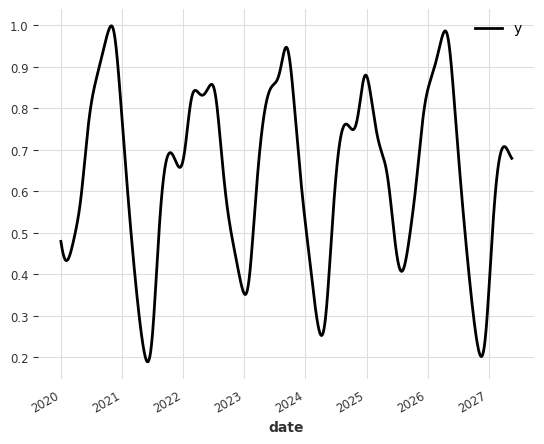

In [31]:
datasets['mackey-glass']['val'].plot()

##########################
chickenpox
##########################


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_8b6c16d9-cfc4-45a6-a7dd-0ad16b95cb0f.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_8b6c16d9-cfc4-45a6-a7dd-0ad16b95cb0f.ckpt


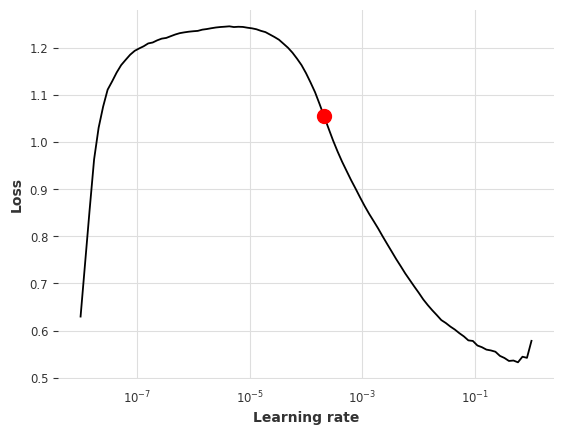

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=70` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

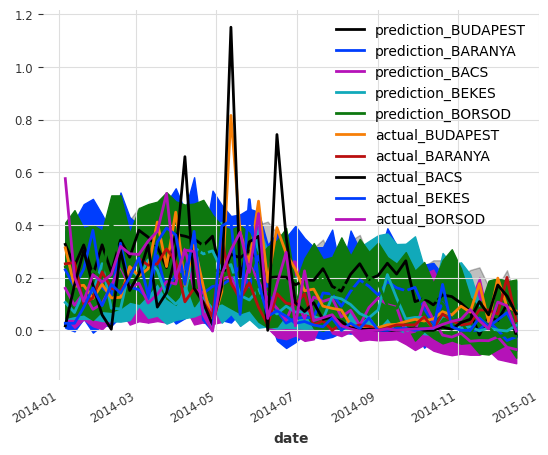

n =  50
mae :  0.10445228574941132
mape :  174.71357009093913
smape :  97.17512934432291
rmse :  0.1434657452360353


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

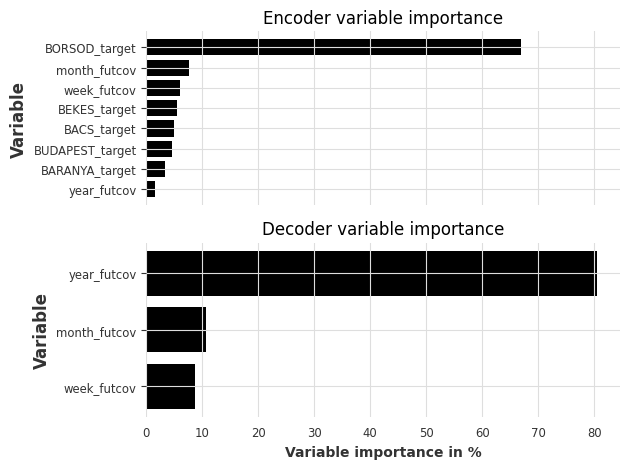

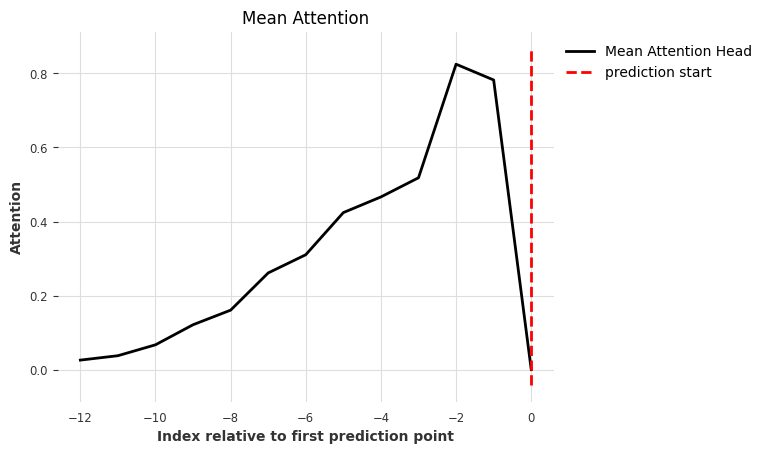

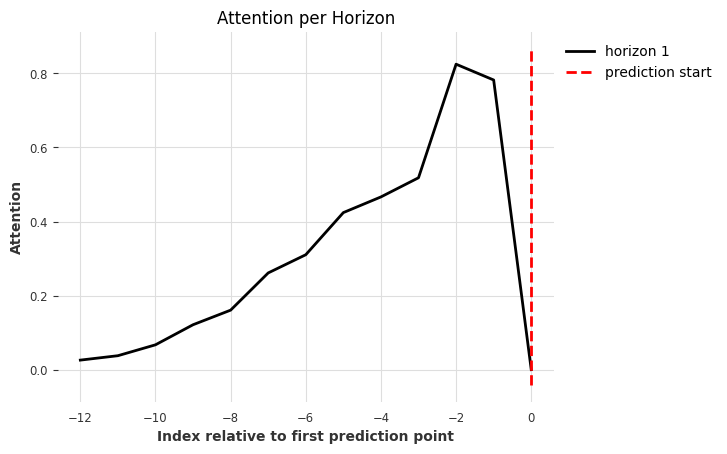

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.


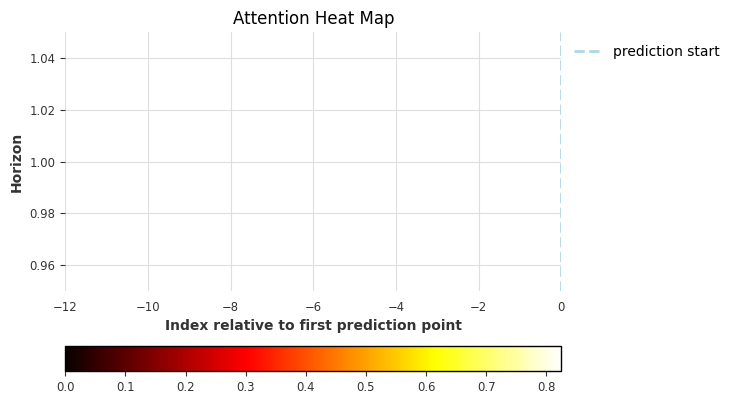

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


##########################
mackey-glass
##########################


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_d25ebabe-e023-418a-b397-aefc8470a308.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_d25ebabe-e023-418a-b397-aefc8470a308.ckpt


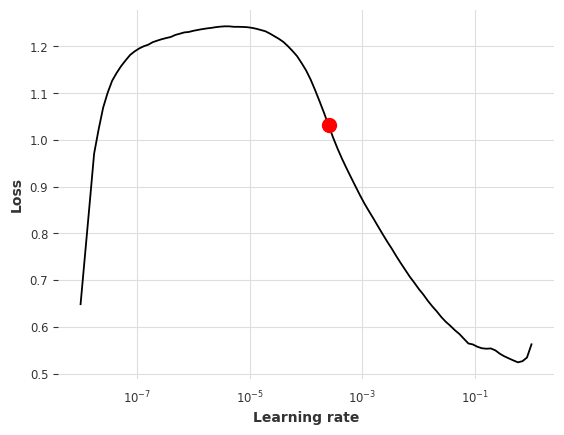

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | 

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=70` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

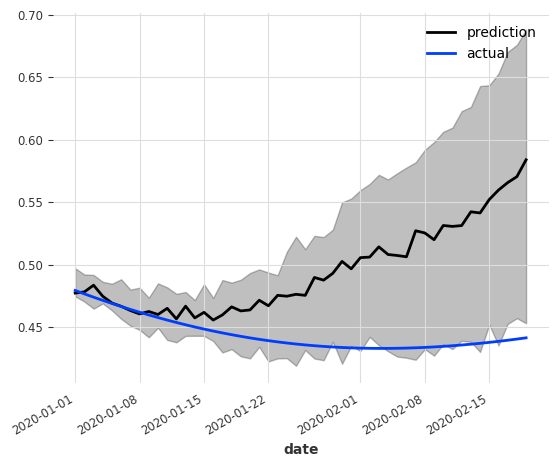

n =  50
mae :  0.050509842528375225
mape :  9.702912174755502
smape :  10.540938764791761
rmse :  0.06587198765265619


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

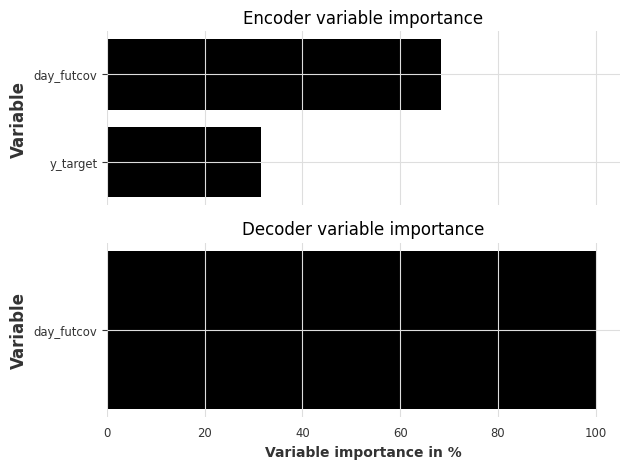

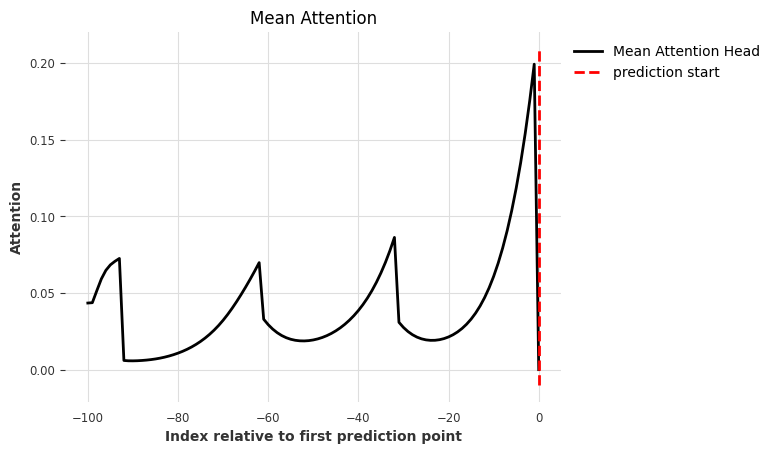

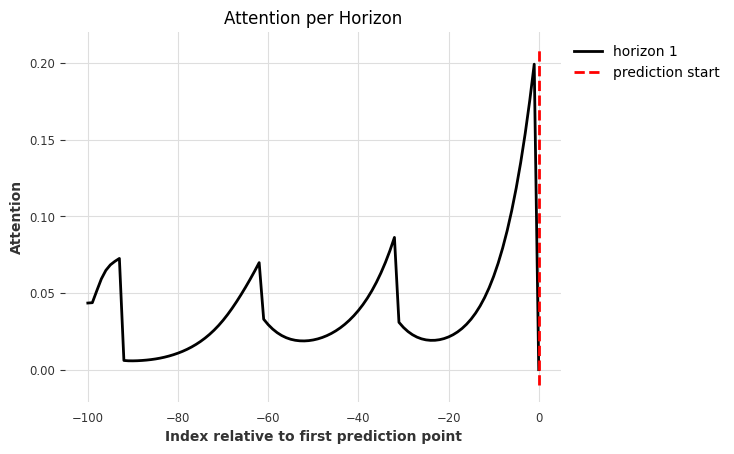

Attempting to set identical low and high ylims makes transformation singular; automatically expanding.


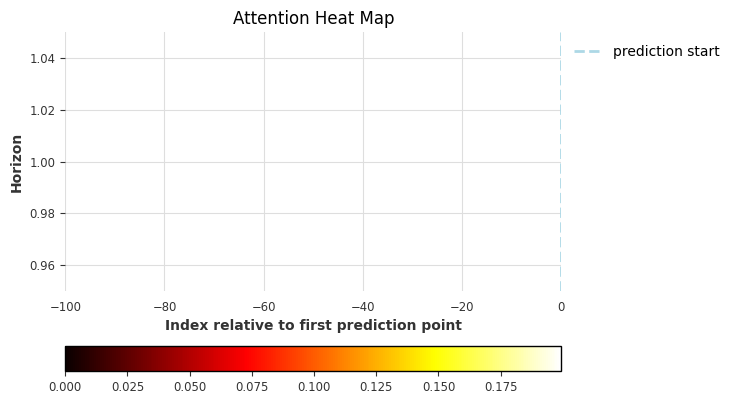

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


##########################
electricity
##########################


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=100` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/.lr_find_a79f0892-b2f9-40b6-9f4e-2b4e9603c53a.ckpt
INFO:pytorch_lightning.utilities.rank_zero:Restored all states from the checkpoint at /content/.lr_find_a79f0892-b2f9-40b6-9f4e-2b4e9603c53a.ckpt


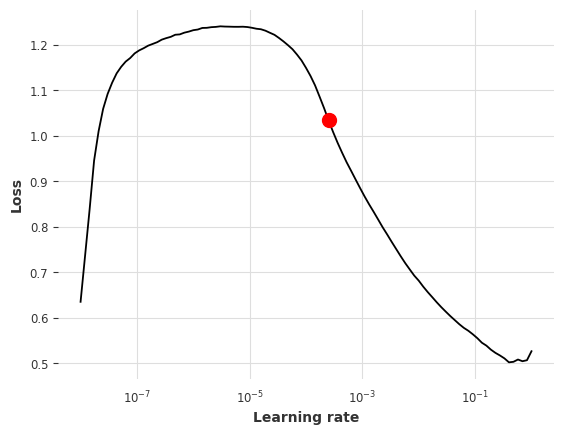

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | train_metrics                     | MetricCollection                 | 0     
1  | val_metrics                       | MetricCollection                 | 0     
2  | input_embeddings                  | _MultiEmbedding                  | 0     
3  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
4  | encoder_vsn                       | 

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
import os
for dataset in datasets.keys():
    print('##########################')
    print(dataset)
    print('##########################')
    curr = datasets[dataset]
    model = train_model(dataset, curr['train'], curr['val'], curr['covariates'], 1, curr['input_length'], n_epochs = 70)
    get_prediction(model, 50, curr['val'], curr['covariates'])
    if os.path.exists(f'/content/drive/MyDrive/tft_results/{dataset}') == False:
        os.mkdir(f'/content/drive/MyDrive/tft_results/{dataset}')
    if os.path.exists(f'/content/drive/MyDrive/tft_results/{dataset}/1') == False:
        os.mkdir(f'/content/drive/MyDrive/tft_results/{dataset}/1')
    model.save(f'/content/drive/MyDrive/tft_results/{dataset}/1/final.model')
    explainer = TFTExplainer(model)
    explainability_result = explainer.explain()
    explainer.plot_variable_selection(explainability_result)
    explainer.plot_attention(explainability_result, plot_type="time")
    explainer.plot_attention(explainability_result, plot_type="all")
    explainer.plot_attention(explainability_result, plot_type="heatmap")

### Many steps ahead prediction
Here we only consider next 24 hours horizon

In [ ]:
for dataset in datasets.keys():
    print('##########################')
    print(dataset)
    print('##########################')
    curr = datasets[dataset]
    model = train_model(dataset, curr['train'], curr['val'], curr['covariates'], curr['future_length'], curr['input_length'], n_epochs = 70)
    get_prediction(model, 50, curr['val'], curr['covariates'])
    length=  curr['future_length']
    if os.path.exists(f'/content/drive/MyDrive/tft_results/{dataset}/{length}') == False:
        os.mkdir(f'/content/drive/MyDrive/tft_results/{dataset}/{length}')
    model.save(f'/content/drive/MyDrive/tft_results/{dataset}/{length}/final.model')
    explainer = TFTExplainer(model)
    explainability_result = explainer.explain()
    explainer.plot_variable_selection(explainability_result)
    explainer.plot_attention(explainability_result, plot_type="time")
    explainer.plot_attention(explainability_result, plot_type="all")
    explainer.plot_attention(explainability_result, plot_type="heatmap")